# Capstone Project

## Introduction/Business Problem

#####     Buenos Aires is the capital of Argentina and one of the best city to live in Latin America , it has a population of at least 2.89 million people spread in 48 neighborhoods and 13 communes, in this project we will study Buenos Aires because i've the intention of moving over the in this year.
         
#####     To move over there, first we will do an analysis  based on the cost of rent and if the area is considered safe or not, here we look for the minimum cost of rent having  the lowest crime rate possible, this is very difficult due to safe areas are expensive and their is a budget to consider.Another aspect to keep in mind is the amount of jobs sources close to the neighborhood and the ease to move around the city.

#####    A preselection will be done just based on crime rate and rent price (Cluster Analysis), then of the remaining neighborhoods we seek the ones with the most job offers and transportation methods.

## Data 

### Data Description

#### For the Map the of the neighborhoods of Buenos Aires we used the geojson data provided by the portal of the mayoralty of Buenos Aires data(https://data.buenosaires.gob.ar/dataset/barrios), the rest of the data was also extract from this portal:

#### * Rent (https://www.estadisticaciudad.gob.ar/eyc/?p=62993)

#### * Crimes (https://e-8ef01e7270.cognitiveclass.ai/download/data/delitos.csv), to handle missing data, we seek                  alternative in real state web pages. 


## Methodology

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install bokeh --yes
print("Bokeh ready!")
from bokeh.plotting import figure
from bokeh.io import output_file, show,output_notebook
from bokeh.plotting import ColumnDataSource
from bokeh.models import HoverTool


import seaborn as sns
print('Libraries imported.')


Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37hdd07704_0
  - defaults/linux-64::scikit-imag

## Import Datasets

In [2]:
df = pd.read_excel("/resources/data/barrios1.xlsx")# import the Neighbourhood dataset
crime = pd.read_csv("/resources/data/delitos.csv") # crime dataset



## Exploratory Data Analysis

##### First we check the column names and the first rows of the dataset, consistency in the names of the columns is required for future merges between data frames, so if a name is not proper we change it. After calculate the amount of missing data, if is significant that column must be dropped, also other columns that wont be use in the analysis have to be drop.

In [3]:
df.drop('Unnamed: 0',axis = 1, inplace = True) # drop unncesary columns
df.rename(columns = {"lng":"lat","lat":"lng"})
df.head()

,Neighbourhood,commune,lat,lng
0,CHACARITA,15,-34.588372,-58.454175
1,PATERNAL,15,-34.597421,-58.468665
2,VILLA CRESPO,15,-34.598834,-58.442722
3,VILLA DEL PARQUE,11,-34.604247,-58.490677
4,ALMAGRO,5,-34.609227,-58.421745


In [4]:
print('The dataframe has  {} neighborhoods.'.format( 
        len(df['Neighbourhood'].unique()),
        df.shape[0]))

The dataframe has  48 neighborhoods.


##### Let's use the coordinates of Buenos Aires to center the map, and the coordinates of the neighborhoods to point where they are.

In [5]:
address = 'Buenos Aires'

geolocator = Nominatim(user_agent="ba_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The  coordinates of Buenos Aires are {}, {}.'.format(latitude, longitude))

The  coordinates of Buenos Aires are -34.6075616, -58.437076.


In [6]:
# create map of New York using latitude and longitude values
map_ba = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neig, com  in zip(df['lat'], df['lng'],df['Neighbourhood'],df['commune']):
    label = '{}, {}'.format(neig , com)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ba)  
    
map_ba

##### Check the first rows of the crime dataset.

In [7]:
# check the data 
crime.head()

,id,comuna,barrio,latitud,longitud,fecha,hora,uso_arma,uso_moto,lugar,origen_dato,tipo_delito,cantidad_vehiculos,cantidad_victimas
0,68313,Comuna 7,FLORES,-34.647598,-58.442600,2016-01-31,19:50:00,SIN USO DE ARMA,SIN MOTO,NaN,NaN,Homicidio Doloso,0,0
1,130524,Comuna 9,LINIERS,-34.639801,-58.529701,2016-01-31,12:00:00,SIN USO DE ARMA,SIN MOTO,NaN,NaN,Robo (Con violencia),0,0
2,130582,Comuna 9,LINIERS,-34.638802,-58.527500,2016-01-31,08:30:00,SIN USO DE ARMA,SIN MOTO,NaN,NaN,Robo (Con violencia),0,0
3,130586,Comuna 10,VILLA REAL,-34.618000,-58.527302,2016-01-31,20:30:00,SIN USO DE ARMA,SIN MOTO,NaN,NaN,Hurto Automotor,0,0
4,130615,Comuna 9,LINIERS,-34.645599,-58.526501,2016-01-31,20:24:00,SIN USO DE ARMA,SIN MOTO,NaN,NaN,Robo (Con violencia),0,0


In [8]:
# check the NaN of these columns
print(crime[["lugar","origen_dato"]].isna().sum(),'\n', #calculate how much NaN are to drop them.
crime[["cantidad_vehiculos","cantidad_victimas"]].sum())
#Drop columns
crime.drop(["id","lugar","origen_dato","cantidad_vehiculos","cantidad_victimas","fecha"],axis = 1, inplace = True )




lugar          350980
origen_dato    350980
dtype: int64 
 cantidad_vehiculos      0
cantidad_victimas     412
dtype: int64


In [9]:
crime.head()
crime.columns = ["commune","Neighbourhood","lat","lng","time","gun","bike","type_crime"] #rename columns

##### To know which neigbourhood is the dangerous, we group by the column "Neighbourhood" and apply the size method to count how many crimes were commited, then we rename the new column, and estimate a new column call "Pct" that is the percentage of crimes, we sort the values from most dangerus to least.

In [10]:
# Crime per Neighbourhood
crime_Ng = pd.DataFrame(crime.groupby("Neighbourhood").size()) # count crimes in each Neighbourhood
crime_Ng.columns = ["Total"] #name column of count
crime_Ng["Pct"] = crime_Ng["Total"]/len(crime)  # pct column
crime_Ng.sort_values("Total",ascending = False,inplace = True) 
display(crime_Ng.describe(),crime_Ng.head())
crime_Ng = crime_Ng.reset_index()

,Total,Pct
count,48.000000,48.000000
mean,7250.375000,0.020658
std,5905.397202,0.016825
min,338.000000,0.000963
25%,3482.250000,0.009922
50%,5549.000000,0.015810
75%,8590.250000,0.024475
max,27689.000000,0.078891


,Total,Pct
Neighbourhood,,
PALERMO,27689,0.078891
BALVANERA,23195,0.066086
FLORES,18792,0.053542
SAN NICOLAS,17319,0.049345
CABALLITO,16703,0.047590


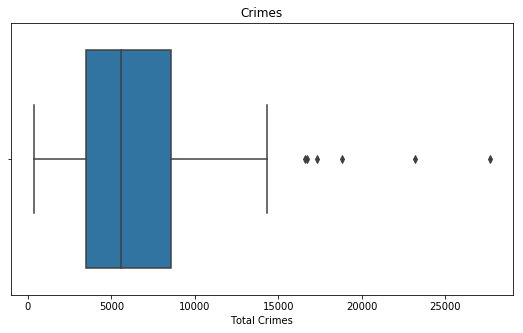

In [11]:
#Data Visuliation
fig, ax = plt.subplots(figsize=(9,5))
ax = sns.boxplot( x = "Total",data = crime_Ng)
ax.set_title("Crimes")
ax.set_xlabel("Total Crimes")
plt.show()

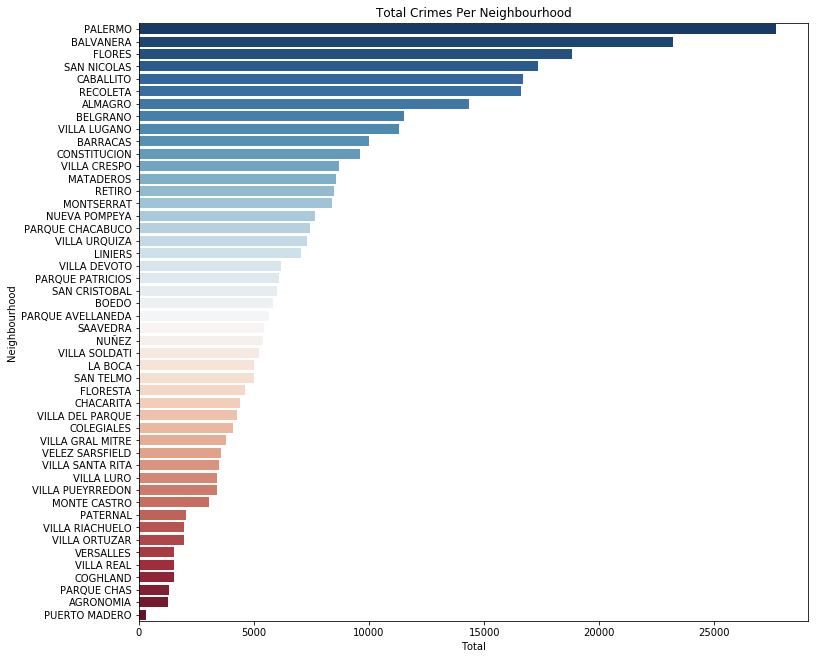

In [12]:
#Data Visuliation
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,11))
ax =sns.barplot(y = "Neighbourhood", x = "Total",data = crime_Ng , palette = "RdBu_r")
ax.set_title("Total Crimes Per Neighbourhood")
plt.show()

##### We can see that Palermo is the most dangerous neighborhood in Buenos Aires with 27698 crimes and Puerto Madero is the least dangerous with just 338, around 90 times less than Palermo. The median, mean and standard deviation of crimes per neighborhood are 5549, 7250, and , 5905.

##### After dertiminated which are the mos dangerous and safe neighborhoods, it's important to know which type of crimes are commited the most, to do this we group by the column "type_crime" and apply the size method and sort in descending order.

In [13]:
 #Type of Crimes
crime_ty = pd.DataFrame(crime.groupby("type_crime").size()) # count crimes in each Neighbourhood
crime_ty.columns = ["Total"] #name column of count
crime_ty["Pct"] = crime_ty["Total"]/len(crime)  # pct column
crime_ty.sort_values("Total",ascending = False,inplace = True) 
crime_ty =crime_ty.reset_index()
display(crime_ty)

,type_crime,Total,Pct
0,Robo (Con violencia),200374,0.570899
1,Hurto (Sin violencia),112301,0.319964
2,Hurto Automotor,18010,0.051313
3,Lesiones Seg Vial,9833,0.028016
4,Robo Automotor,9793,0.027902
5,Homicidio Doloso,405,0.001154
6,Homicidio Seg Vial,264,0.000752


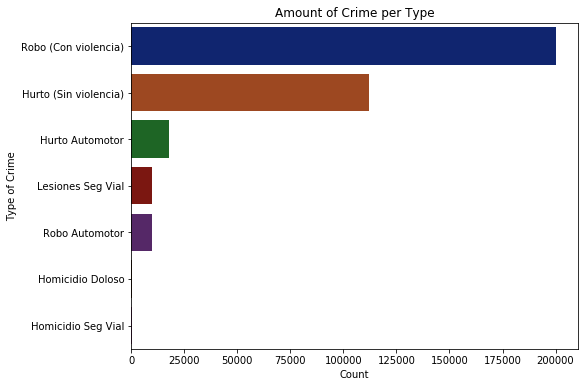

In [14]:
#Count of crimes
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(y = "type_crime", x = "Total",data = crime_ty, palette = "dark")
ax.set_title("Amount of Crime per Type")
ax.set_ylabel("Type of Crime")
ax.set_xlabel("Count")
plt.show()

##### From the previous data we can see that "Theft with violence" is the most common crime and "Homicide road Safety" is the least common, we can also say that the rate of murder("Homicide" per 100000 inhabitants) in Buenos Aires is low compare to other main cities  in Latin America like Brazil, Honduras, Venezuela, Mexico, among others.

##### Finally we look at which are the most commons crimes in each neighborhood, we repeat the process of group by, in this case two columns "type_crime"and "Neighborhood" and applying the size method.

In [15]:
#type of crime in Neighbourhood
crime_tn = pd.DataFrame(crime.groupby(["Neighbourhood","type_crime"]).size()) # count crimes in each Neighbourhood
crime_tn.columns = ["Total"] #name column of count
crime_tn.reset_index(inplace = True)
#crime_tn.head

##### To see which hour is the mos dangerous in the city, fisrt check if the column type is appropiate to work with, if isn't we convert to a date type, then extract the hour and assign it in to a list, then we create a new column call  "hour", finally we repeat the group by process and method size.

In [16]:
type(crime.time[0]) #check the tyoe of var

str

In [17]:
 time = pd.to_datetime(crime.time) #change to datetime

In [18]:
 type(time[0]) #check change

pandas._libs.tslibs.timestamps.Timestamp

In [19]:
hour = []
for i in time:
    hour.append(i.hour) #extract the hour as a number for every crime

In [20]:
crime["time"] = hour #assing the new column to the orignal DataFrame
hour = pd.DataFrame(hour) # make a Dataframe for plotting
hour.columns =["hour"] #assign name


In [21]:
time1 = pd.DataFrame(hour.groupby("hour").size())
time1.reset_index(inplace = True)
time1.columns  = ["hour","count"]

In [22]:
time1["pct"] = time1["count"]/len(time)
time1.head()

,hour,count,pct
0,0.0,15620,0.044504
1,1.0,7588,0.021619
2,2.0,5922,0.016873
3,3.0,5038,0.014354
4,4.0,5014,0.014286


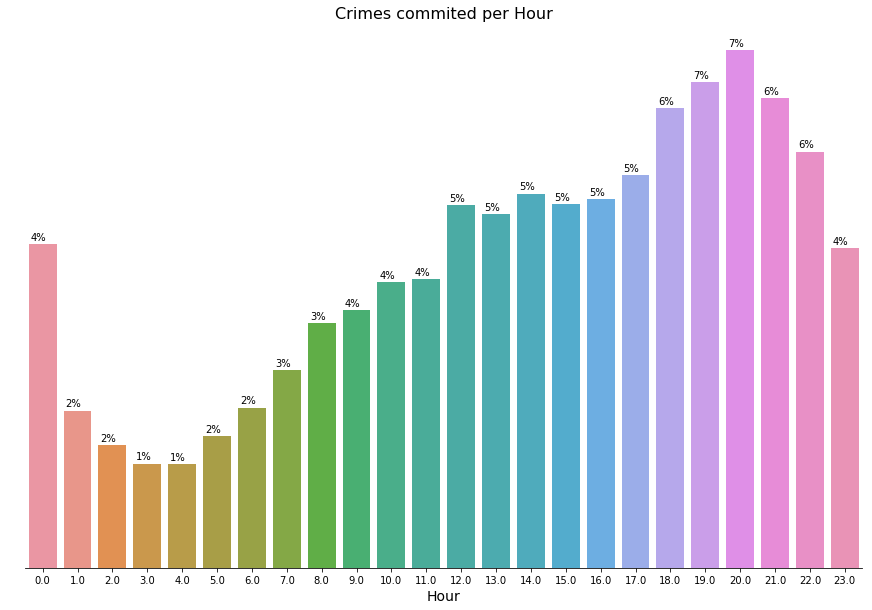

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x = "hour" ,y = "pct", ax=ax,data = time1)


ax.set_xlabel("Hour",fontsize = 14)
ax.set_title("Crimes commited per Hour",fontsize = 16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylabel(" ",fontsize = 14)
for i in ax.patches:
    p_x = i.get_x()
    p_y = i.get_height()
    ax.annotate(xy = (p_x + 0.06, p_y + 0.001 ), 
            s = "{:.0f}%".format(round(p_y*100, 0)), 
            ha = 'left', va='center', fontsize=10)
    
    
plt.yticks([])
plt.show()
plt.show()

In [24]:
display(time1[["hour","count"]].corr())

,hour,count
hour,1.00000,0.83997
count,0.83997,1.00000


##### We can see that 64% of the crimes are happened in the second half of the day, and between six and 10 p.m. 32% of the crimes are committed, clearly the preferred time is by the night, when usually more people go out for distraction.

In [25]:
#a = [1,2,3,4,5]
#for i in a:
#    fig, ax = plt.subplots(figsize=(7.5,10))
#    ax = sns.regplot(x = "hour" ,y = "count", ax=ax,data = time1,order =i)
#    ax.set_xlabel("Hour",fontsize = 14)
#    ax.set_ylabel("Count",fontsize = 16)
#    ax.set_title("Crimes per Hour, order of cruve {}".format(i),fontsize = 16)

## Import Dataset

In [26]:
alq = pd.read_excel("/resources/data/alquileres.xlsx")

In [27]:
alq.head()

,Barrio,Jan-18,Feb-18,Mar-18,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,Nov-18,Dic-18,Jan-19,Feb-19,Unnamed: 15,Unnamed: 16
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Month,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,NaN,NaN
2,Agronomia,8749.352172,9019.950693,9298.918240,9586.513650,9883.003763,10188.663673,10503.776982,10828.636064,11163.542334,11508.806530,11864.749000,12231.700000,12610.000000,13000.000000,NaN,NaN
3,Almagro,10835.856068,11296.491921,11866.053714,11794.649665,12229.569135,12236.569347,12508.712121,12849.949648,13071.902655,13015.321036,13577.017903,14125.432954,14194.618914,14769.392034,NaN,NaN
4,Balvanera,10024.995193,10609.366828,9898.788416,9975.551250,10789.872309,10401.322651,11181.434599,11743.394748,12131.900051,12630.165341,12674.383789,13013.084724,13405.335968,14016.958628,NaN,NaN


In [28]:
 #drop first row, and las two columns
rent = alq.iloc[2:,0:13]  #just working with data from the 2018 
rent["Barrio"] = rent["Barrio"].str.upper()
rent.describe()

,Jan-18,Feb-18,Mar-18,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,Nov-18,Dic-18
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,10936.879818,11140.398896,11346.040447,11562.929952,11715.080608,12001.756055,12226.559592,12484.370729,12712.249091,12981.192744,13248.942757,13406.471821
std,1809.951692,1725.535870,1828.517364,1829.671038,1803.046565,1942.156100,2008.018839,2120.349259,2221.986244,2382.250175,2493.652214,2625.393648
min,6365.375643,6508.564052,6654.973468,6804.676348,6957.746777,7114.260508,7274.294998,7437.929446,7605.244832,7776.323959,7951.251492,8130.114000
25%,9844.589884,10193.374802,10200.873165,10465.796122,10615.996920,10671.937967,11149.847859,11203.184730,11833.715282,11928.306509,12126.921018,12158.793750
50%,10655.340655,11112.463978,11373.414759,11584.168578,11741.567787,11958.848214,12440.538422,12597.316518,12634.700463,12770.703041,13040.037398,13236.727836
75%,12196.628495,12349.177311,12427.454310,12570.347039,12922.290346,12956.208437,13262.957440,13757.576319,13338.295187,14284.533764,14605.341432,14698.125462
max,17777.100538,17395.006140,18506.302784,18664.734017,18503.868922,19429.062368,20400.515487,21420.541261,22491.568324,23616.146740,24796.954077,26036.801781


In [29]:
rent_month = pd.DataFrame(rent.mean())
rent_month["month_n"] = range(1,13) 
rent_month.columns = ["mean_rent","month_n"]
rent_month["mean_rent"] = rent_month["mean_rent"]//30 # divide to 30 to get the price per squere

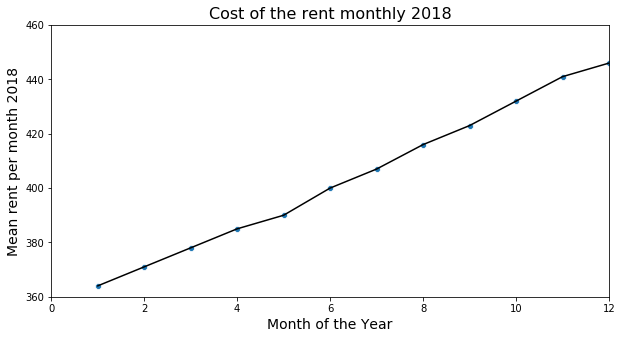

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.set_style("whitegrid")
ax = sns.lineplot(x = "month_n",
                  y = "mean_rent",
                  data = rent_month,
                  color = "k")
ax = sns.scatterplot(x = "month_n",
                  y = "mean_rent",
                  data = rent_month
                    ) 
ax.set_title("Cost of the rent monthly 2018", size = 16)
ax.set_ylabel("Mean rent per month 2018", size = 14)
ax.set_xlabel("Month of the Year", size = 14)
ax.set_ylim(360,460)
ax.set_xlim(0,12)
plt.show()

In [31]:
rent_ng = pd.DataFrame(rent.mean(axis = 1))
rent_ng["Neighbourhood"] = rent["Barrio"] 
rent_ng.columns = ["mean_rent","Neighbourhood"]
rent_ng["mean_rent"] = rent_ng["mean_rent"]//30
rent_ng = rent_ng.sort_values("mean_rent",ascending = False)
rent_ng.head()

,mean_rent,Neighbourhood
28,691.0,PUERTO MADERO
23,487.0,PALERMO
22,471.0,NUÑEZ
11,468.0,COGHLAN
43,468.0,VILLA ORTUZAR


In [32]:
rent.rename(columns = {"Barrio":"Neighbourhood"},inplace = True)

display(rent.head(),
        rent.shape)


,Neighbourhood,Jan-18,Feb-18,Mar-18,Apr-18,May-18,Jun-18,Jul-18,Aug-18,Sep-18,Oct-18,Nov-18,Dic-18
2,AGRONOMIA,8749.352172,9019.950693,9298.918240,9586.513650,9883.003763,10188.663673,10503.776982,10828.636064,11163.542334,11508.806530,11864.749000,12231.700000
3,ALMAGRO,10835.856068,11296.491921,11866.053714,11794.649665,12229.569135,12236.569347,12508.712121,12849.949648,13071.902655,13015.321036,13577.017903,14125.432954
4,BALVANERA,10024.995193,10609.366828,9898.788416,9975.551250,10789.872309,10401.322651,11181.434599,11743.394748,12131.900051,12630.165341,12674.383789,13013.084724
5,BARRACAS,10156.110917,10258.697896,10362.321107,10466.991018,10572.718200,10679.513333,10787.387205,10896.350712,11006.414861,11465.015480,11942.724458,11578.000000
6,BELGRANO,12350.029824,12487.986663,12709.180187,13107.855183,13720.038682,12985.935381,13904.676185,14319.031595,14779.972532,15120.813424,15112.289066,15479.834396


(48, 13)

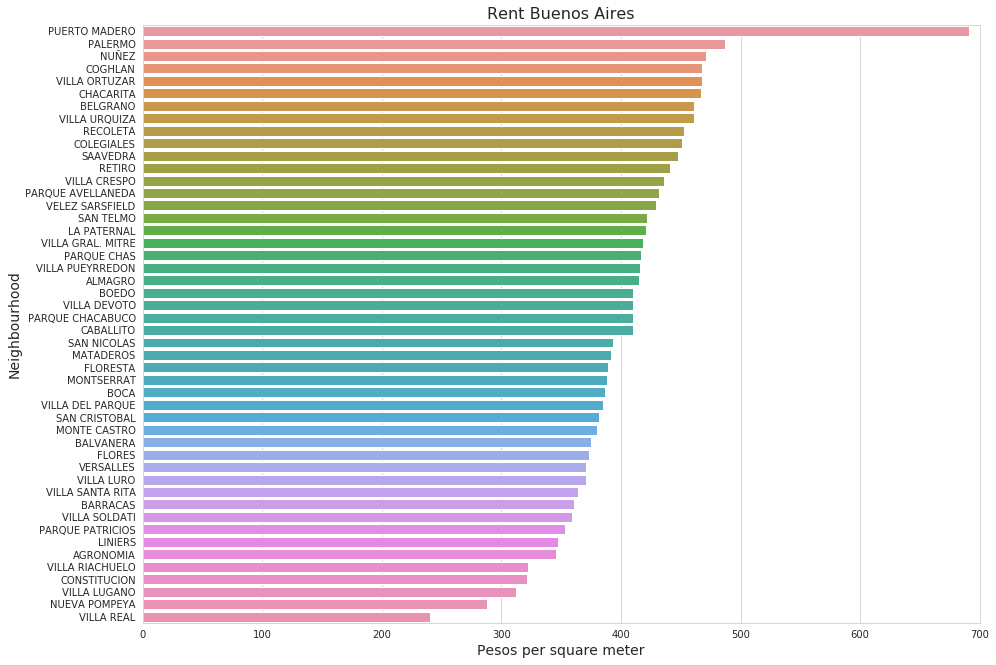

In [33]:
fig, ax = plt.subplots(figsize=(15,11))
ax = sns.barplot(y = "Neighbourhood", 
            x = "mean_rent",
            data = rent_ng 
           )
ax.set_xlim(0,700)
ax.set_title("Rent Buenos Aires",size = 16)
ax.set_xlabel("Pesos per square meter",size = 14)
ax.set_ylabel("Neighbourhood",size = 14)
plt.show()

##### Here we can apreciate how all most statistical indicator have gone up from January to December, in the first chart we can see that the trend is up for all months.

##### Also we can see that Puerto Madero is by more than 200 pesos per square meter is the most exclusive neighborhood in all Buenos Aires, this area of the city is full of new and modern real state development and is one of the most popular neighborhood for turism, also happened to be one the safestest area in all the city.

##### Then we can say that the rest of the neighborhood are between 500 and 300 pesos per square meter, 22 in the range of 499 to 400 and 23 in the range of 399 to 300.

In [34]:
crime_rent = pd.merge(crime_Ng,rent_ng, on = "Neighbourhood")
crime_rent.drop("Pct",axis=1,inplace = True) 


In [35]:
ba_df = pd.merge(crime_rent,df ,on = "Neighbourhood")
ba_df = ba_df.rename(columns = {"Total":"Total_Crimes" ,"mean_rent":"Psm"})
display(ba_df.head())

,Neighbourhood,Total_Crimes,Psm,commune,lat,lng
0,PALERMO,27689,487.0,14,-34.573902,-58.422435
1,BALVANERA,23195,375.0,3,-34.609099,-58.403062
2,FLORES,18792,373.0,7,-34.636803,-58.458268
3,SAN NICOLAS,17319,393.0,1,-34.603666,-58.380515
4,CABALLITO,16703,410.0,6,-34.616825,-58.443603


In [36]:
output_notebook()

Loading BokehJS ...

In [37]:
source = ColumnDataSource(ba_df)
p1 = figure(x_axis_label = "Price per Squre meter",y_axis_label = "Total Crimes")
p1.circle(y = 'Total_Crimes',
          x = 'Psm',
          source = source,
          size=10)
hover = HoverTool(tooltips=[
                    ('Neighbourhood','@Neighbourhood'),
                    ('Price','@Psm'),
                    ('Total Crimes','@Total_Crimes')
                    ])
p1.add_tools(hover)
output_file('cri-psm.html')
show(p1)

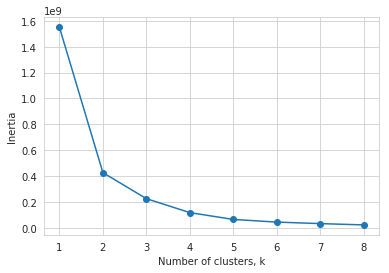

In [38]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
drop =["commune"]#,"lat","lng"]
X = ba_df.drop(drop,axis =1).values[:,1:]

#X = np.nan_to_num(X)
cluster_dataset =Normalizer().fit_transform(X)
#cluster_dataset
ks = range(1, 9)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()


In [39]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=20)
k_means.fit(cluster_dataset)
labels = k_means.labels_
centers = k_means.cluster_centers_
print(labels,centers)

[0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 3 0 3 3 3 3 3 3 3 3 3 4 3 4 4 4 4 4 4 4 2
 2 4 2 2 1] [[ 0.9994187   0.03177854 -0.0029153  -0.00492042]
 [ 0.43769747  0.89481938 -0.04481744 -0.07556848]
 [ 0.96511427  0.25655844 -0.02247777 -0.03800053]
 [ 0.99738956  0.070221   -0.00599605 -0.0101238 ]
 [ 0.99184565  0.12328352 -0.01190366 -0.02010914]]


In [40]:
ba_df["Labels"] = labels
ba_df.head()

,Neighbourhood,Total_Crimes,Psm,commune,lat,lng,Labels
0,PALERMO,27689,487.0,14,-34.573902,-58.422435,0
1,BALVANERA,23195,375.0,3,-34.609099,-58.403062,0
2,FLORES,18792,373.0,7,-34.636803,-58.458268,0
3,SAN NICOLAS,17319,393.0,1,-34.603666,-58.380515,0
4,CABALLITO,16703,410.0,6,-34.616825,-58.443603,0


In [41]:
ba_df_mean = pd.DataFrame(ba_df.groupby('Labels')[["Total_Crimes","Psm"]].mean()).reset_index()
ba_df_mean["Count"] = ba_df["Labels"].value_counts()
ba_df_mean["Labels"] = ba_df_mean["Labels"].astype('category')

display(ba_df_mean,
        ba_df_mean["Total_Crimes"].std(),
        ba_df_mean["Psm"].std())

,Labels,Total_Crimes,Psm,Count
0,0,13934.866667,388.266667,15
1,1,338.000000,691.000000,1
2,2,1525.750000,400.500000,4
3,3,5963.615385,407.846154,13
4,4,3208.555556,382.222222,9


5426.190112496672

132.88561111576396

In [42]:
output_notebook()
source = ColumnDataSource(ba_df_mean)
 
p1 = figure(x_axis_label = "Cluster",y_axis_label = "Count")
p1.vbar(top = 'Count',
        x = 'Labels',
        source = source,
        width = 0.9)
hover = HoverTool(tooltips=[
                    ('Mean Total Crimes','@Total_Crimes'),
                    ('Mean Rent Cost','@Psm')])
p1.add_tools(hover)
output_file('mean.html')
show(p1)

Loading BokehJS ...

## Results

##### To classify the neighborhoods, first we merge the data frames containing the crimes, rent cost and locations of each neighborhood, then we drop the column "commune", and extract the values of these columns.

##### Is necessary apply a machine learning classification method, in this case KMeans,first the "Elbow Method" was applied, and select the number where the slope start to decrease her decline the most, in this case is 5 so that will be the number of cluster to use. After that sort out the neighborhood, and attach their label to the data frame and convert to a category type.


##### To obtain the characteristic of each category, the mean method was apply:

##### Category:0 There are 15 neighborhoods, that have  a mean price per square meter of 405.67 and a mean rate crime of 6219 per year.
##### Category:1 There is 1 neighborhood, Palermo, it has  a mean price per square meter of 691 (max rent price) and a mean rate crime of 338 (min total crime) per year.
##### Category:2 There are 4 neighborhoods, that have  a mean price per square meter of 400.5 and a mean rate crime of 1526 per year.
##### Category:3 There are 9 neighborhoods, that have  a mean price per square meter of 382.22 and a mean rate crime of 3209 per year.
##### Category:4 There are 13 neighborhoods, that have  a mean price per square meter of 387.77 and a mean rate crime of 14867.15 per year.

##### The only "outlier" is Puerto Madero it has the highest rent and the lowest crime rate in all the city, then  deviation in rent price for the rest of the clusters is just 133 pesos per square meter looking to the crime stats the range is much wider than for the rent, here the deviation is 5427 crimes, so it can be said that the crime rate is the biggest difference between the clusters, and its a fundamental factor, also the rent prices  are packed in big groups, the don't differ that much from neighborhood to neighborhood.

##### Finally a representation of the category is made with an interactive bar chart, that provides the characteristics of each cluster.


In [43]:
ba_df_2 = ba_df[ba_df.Labels == 2]
ba_df_3 = ba_df[ba_df.Labels == 3]
ba_df_23 = ba_df_2.append(ba_df_3)

In [44]:
display(ba_df_23)

,Neighbourhood,Total_Crimes,Psm,commune,lat,lng,Labels
36,VILLA ORTUZAR,1960,468.0,15,-34.580973,-58.467651,2
37,VERSALLES,1528,371.0,10,-34.630123,-58.522417,2
39,PARQUE CHAS,1336,417.0,15,-34.585523,-58.479121,2
40,AGRONOMIA,1279,346.0,15,-34.592945,-58.488673,2
13,RETIRO,8488,441.0,1,-34.588412,-58.375922,3
15,PARQUE CHACABUCO,7459,410.0,7,-34.635940,-58.437696,3
16,VILLA URQUIZA,7323,461.0,12,-34.571541,-58.487856,3
18,VILLA DEVOTO,6168,410.0,11,-34.602355,-58.514282,3
19,PARQUE PATRICIOS,6103,353.0,4,-34.637550,-58.401675,3
20,SAN CRISTOBAL,5989,382.0,3,-34.623865,-58.401884,3


In [45]:
dist =[]
from geopy.distance import geodesic
for lat,lng in zip(ba_df_23["lat"],ba_df_23["lng"]):
    dwtn = (-34.60389, -58.37056)
    dist.append(geodesic(dwtn,(lat,lng)).kilometers)


In [46]:
ba_df_23["dist (km)"] = dist

In [47]:
ba_df_23

,Neighbourhood,Total_Crimes,Psm,commune,lat,lng,Labels,dist (km)
36,VILLA ORTUZAR,1960,468.0,15,-34.580973,-58.467651,2,9.262694
37,VERSALLES,1528,371.0,10,-34.630123,-58.522417,2,14.227842
39,PARQUE CHAS,1336,417.0,15,-34.585523,-58.479121,2,10.165282
40,AGRONOMIA,1279,346.0,15,-34.592945,-58.488673,2,10.902523
13,RETIRO,8488,441.0,1,-34.588412,-58.375922,3,1.786050
15,PARQUE CHACABUCO,7459,410.0,7,-34.635940,-58.437696,3,7.109750
16,VILLA URQUIZA,7323,461.0,12,-34.571541,-58.487856,3,11.343718
18,VILLA DEVOTO,6168,410.0,11,-34.602355,-58.514282,3,13.184293
19,PARQUE PATRICIOS,6103,353.0,4,-34.637550,-58.401675,3,4.699537
20,SAN CRISTOBAL,5989,382.0,3,-34.623865,-58.401884,3,3.628140


In [48]:
ba_df_23 = ba_df_23.sort_values("dist (km)",ascending = True).head()
ba_df_23

,Neighbourhood,Total_Crimes,Psm,commune,lat,lng,Labels,dist (km)
13,RETIRO,8488,441.0,1,-34.588412,-58.375922,3,1.786050
25,SAN TELMO,4986,422.0,1,-34.621520,-58.371541,3,1.957881
20,SAN CRISTOBAL,5989,382.0,3,-34.623865,-58.401884,3,3.628140
19,PARQUE PATRICIOS,6103,353.0,4,-34.637550,-58.401675,3,4.699537
21,BOEDO,5852,410.0,5,-34.629960,-58.418840,3,5.288604


##### Then the cluster to be selected are the one we the lowest crime rate and price per square meter.

##### Chacarita is the clotest neighborhood to the center of the city that is ralative cheap and safe, in the top five clotest to the downtown Chacarita is the one with the most crimes and higher rent, but in this case minimize distance is the main goal so this is the neighborhood selected to move.

## Foresquare

In [49]:
CLIENT_ID = 'YYMWR3DMQYBQSQB3WS4DJYNHBFBZRU5NYLDW3JR1MZHAURSF' # your Foursquare ID
CLIENT_SECRET = '45B3HWT33Y35RKHPXVWKDEZHRPBZCWJC1XH0BAQYFJM5DPE3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YYMWR3DMQYBQSQB3WS4DJYNHBFBZRU5NYLDW3JR1MZHAURSF
CLIENT_SECRET:45B3HWT33Y35RKHPXVWKDEZHRPBZCWJC1XH0BAQYFJM5DPE3


##### Select Chacarita coordinates to extract the venues.

In [50]:
cha_lat = ba_df_23.iloc[0,4]
cha_lng = ba_df_23.iloc[0,5]
display(cha_lat,cha_lng)

-34.58841231203454

-58.37592172603059

###### Look for the top 100 venues that are in Chacarita within a radius of a kilometer

In [51]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
 
radius = 1000 # define radius
 
 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    cha_lat, 
    cha_lng, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=YYMWR3DMQYBQSQB3WS4DJYNHBFBZRU5NYLDW3JR1MZHAURSF&client_secret=45B3HWT33Y35RKHPXVWKDEZHRPBZCWJC1XH0BAQYFJM5DPE3&v=20180605&ll=-34.58841231203454,-58.37592172603059&radius=1000&limit=100'

In [52]:
results = requests.get(url).json()
#results

In [53]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
 

In [54]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

display(nearby_venues.head())

,name,categories,lat,lng
0,Torre Monumental (ex Torre de los Ingleses),Monument / Landmark,-34.592166,-58.373752
1,Florería Atlántico,Speakeasy,-34.591487,-58.379564
2,"Museo Nacional Ferroviario ""Raúl Scalabrini Or...",Museum,-34.589830,-58.379254
3,BASA - Basement Bar & Restaurant,Cocktail Bar,-34.592530,-58.376948
4,Feirs Park Hotel Buenos Aires,Hotel,-34.591757,-58.378163


###### There are 79 venues close to Chacarita, in the next chart we can see which are the most common venues a round Chacarita.

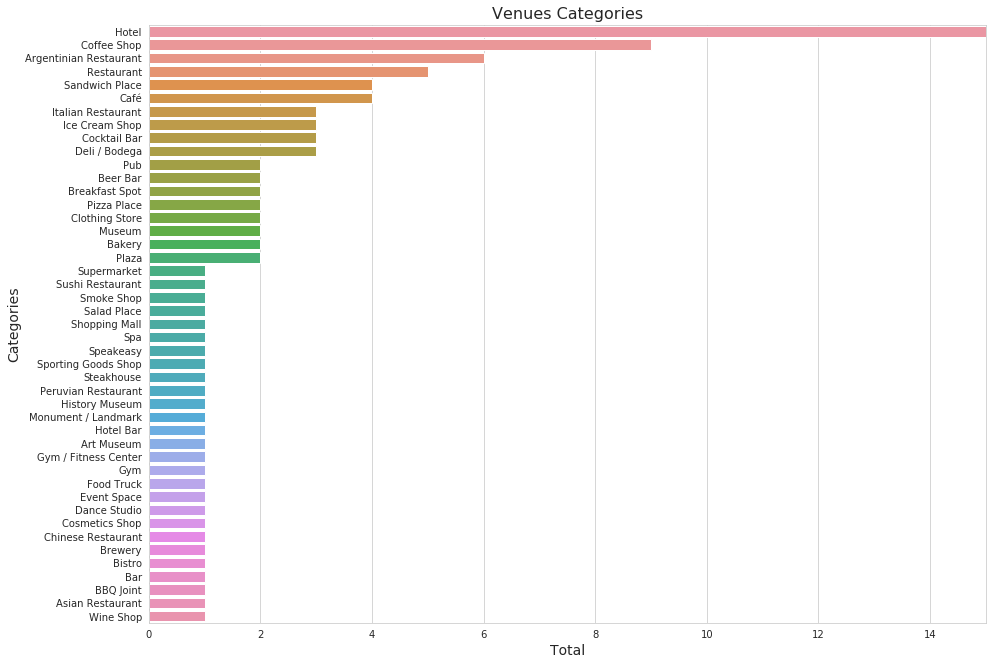

In [55]:
df4 = pd.DataFrame(nearby_venues.groupby("categories").size())
df4.columns = ["total"]
df4 = df4.sort_values("total",ascending = False)
df4 = df4.reset_index()

fig, ax = plt.subplots(figsize=(15,11))
ax = sns.barplot(y = "categories", 
            x = "total",
            data = df4 
           )
ax.set_xlim(0,15)
ax.set_title("Venues Categories",size = 16)
ax.set_xlabel("Total",size = 14)
ax.set_ylabel("Categories",size = 14)
plt.show()



##### The neighbourhood has all the basic store/locals that are needed pharmacy, restaurants, markers, bus stop, swimming pool among others.

In [57]:
with open('/resources/data/barrios.geojson') as json_data:
    ba_data = json.load(json_data)
map_ba2 = folium.Map(location=[latitude, longitude], zoom_start=11)

 

map_ba2.choropleth(
    geo_data=ba_data,
    data=rent_ng,
    columns=['Neighbourhood', 'mean_rent'],
    key_on='feature.properties.BARRIO',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Rent Price per Square Meter Buenos Aires'
)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in (range(num_clusters))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ba_df['lat'], ba_df['lng'], ba_df['Neighbourhood'], ba_df['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_ba2)
       


map_ba2

In [59]:
map_ba1 = folium.Map(location=[latitude, longitude], zoom_start=11)

with open('/resources/data/barrios.geojson') as json_data:
    ba_data = json.load(json_data)

map_ba1.choropleth(
    geo_data=ba_data,
    data=crime_Ng,
    columns=['Neighbourhood', 'Total'],
    key_on='feature.properties.BARRIO',
    fill_color='RdBu_r', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crime Rate Buenos Aires'
)


# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in (range(num_clusters))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ba_df['lat'], ba_df['lng'], ba_df['Neighbourhood'], ba_df['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_ba1)
       


map_ba1

## Discussion

##### One of the aspects that stand out the most is that the average rent in Buenos Aires increased 24% the las year, one of the main reason is the financial situation in Argentina where inflation is one of the highest in the world.

##### Most of the crimes were committed between 5 to 10 pm. so the law enforcement institutions should place more platrols  at this hours in the most dangerous neighborhoods.

##### More variables can be used like public transportation, job index, or more specific matters depending on the person necessities, there are several neighborhood that have similar characteristic to Chacarita and those can be contemplated to move.

##### The rent data is a bit ambiguous because the majority of the rent required advance deposits, so the prices are a bit higher.

## Conclusion 

##### Data Analysis is a great tool in this case we could detected which are the best neighborhood to move, depending on the variables to analyze. It's important that government institutions  apply these techniques to attack problems they have in their communities like insecurity, traffic, public transportation among others.

##### Also the information should be public in this case to make decision about which neighborhoods the bes to live in or where a business can be started.